In [1]:
# !rm -rf data/ecgs.zarr
# !./ingest_ecg_records.py

In [12]:
import zarr
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
from sklearn.preprocessing import normalize
from sklearn.neighbors import KernelDensity, LocalOutlierFactor

# store = zarr.DirectoryStore("data/ecgs.zarr")
# root = zarr.group(store=store, overwrite=False)
# root = zarr.open("data/ecgs.zarr")

root = zarr.open_group("data/ecgs.zarr", mode="r")
root.info

Name,/
Type,zarr.hierarchy.Group
Read-only,True
Store type,zarr.storage.DirectoryStore
No. members,4
No. arrays,0
No. groups,4
Groups,"beats, cleaned, meta, raw"


In [15]:
print(root.tree())

/
 ├── beats
 │   ├── r_peak_idxs (43099,) object
 │   ├── valid_r_peak_idxs (43099,) object
 │   ├── window_size_400 (43099,) object
 │   ├── window_size_400_normalized (43099,) object
 │   ├── window_size_400_normalized_flattened (801266, 400, 12) float32
 │   ├── window_size_400_outlier (43099,) int32
 │   └── window_size_400_shape (43099, 3) int32
 ├── cleaned
 │   └── p_signal (43099,) object
 ├── meta
 │   └── record_idx_to_window_400_range (1,) object
 └── raw
     ├── dx (43099,) object
     ├── meta (43099, 3) int32
     ├── p_signal (43099,) object
     └── p_signal_shape (43099, 2) int32


In [28]:
root["meta/record_idx_to_window_400_range"][0]["11721"]
# root["beats/window_size_400_normalized_flattened"][0]

[218912, 218923]

In [4]:
def get_signal(idx):
    signal = root["raw/p_signal"][idx].reshape(root["raw/p_signal_shape"][idx], order="C")
    cleaned_signal = root["cleaned/p_signal"][idx].reshape(root["raw/p_signal_shape"][idx], order="C")
    age, sex, fs = root["raw/meta"][idx]
    dx = root["raw/dx"][idx]
    
    beats = root["beats/r_peak_idxs"][idx]
    valid_beats = root["beats/valid_r_peak_idxs"][idx]

#     beat_windows = root["beats/window_size_400"][idx].reshape(root["beats/window_size_400_shape"][idx], order="C")
    beat_windows = root["beats/window_size_400_normalized"][idx].reshape(root["beats/window_size_400_shape"][idx], order="C")

    return signal, cleaned_signal, age, sex, fs, dx, beats, valid_beats, beat_windows


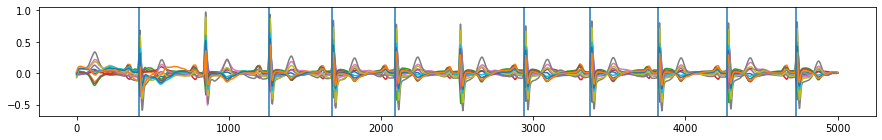

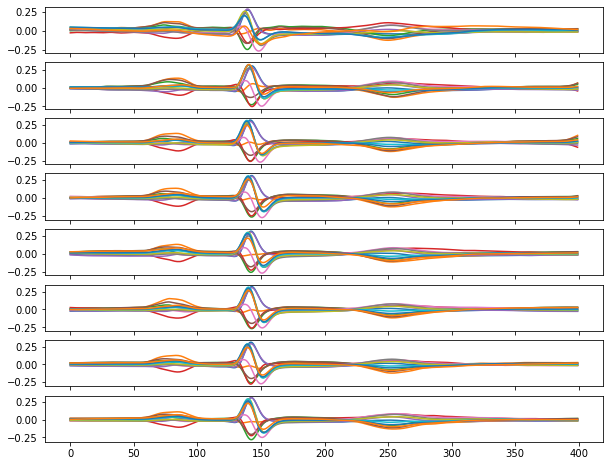

array([[ 2.2773072e-02,  2.2947980e-02, -1.0876814e-03, ...,
         4.6833698e-02,  4.4366010e-02,  2.8845349e-02],
       [ 2.1127319e-02,  2.2506375e-02, -4.3291835e-05, ...,
         4.6502337e-02,  4.4283628e-02,  2.8636388e-02],
       [ 1.9537129e-02,  2.1888059e-02,  8.1794208e-04, ...,
         4.6154071e-02,  4.4094175e-02,  2.8329955e-02],
       ...,
       [-4.1387519e-03,  2.3023106e-02,  2.1752344e-02, ...,
         3.3970007e-03,  6.0760612e-03,  1.6787454e-02],
       [-3.8125180e-03,  2.3461597e-02,  2.1801129e-02, ...,
         3.4289295e-03,  5.4210476e-03,  1.5887421e-02],
       [-3.3934647e-03,  2.4093408e-02,  2.1941384e-02, ...,
         3.5324281e-03,  4.8919241e-03,  1.5017257e-02]], dtype=float32)

In [31]:
(
    signal,
    cleaned_signal,
    age,
    sex,
    fs,
    dx,
    beats,
    valid_beats,
    beat_windows
) = get_signal(13)#(29247)#(14390)#(43098)

# plt.plot(signal)
# plt.show()
fig, axs = plt.subplots(1, figsize=(15, 2))
axs.plot(cleaned_signal)
# print(cleaned_signal.shape)
all_r_peaks_flat = np.concatenate(beats)[:, np.newaxis]
sig_range = np.linspace(0, all_r_peaks_flat.max(), len(cleaned_signal))[:, np.newaxis]
for sc in sig_range[valid_beats]:
    plt.axvline(x=sc)
plt.show()

# find outlier
# clf = LocalOutlierFactor(n_neighbors=len(beat_windows)//2)
# print(clf.fit_predict(beat_windows.reshape(len(beat_windows), -1)))
# print(clf.negative_outlier_factor_)
# outlier_idx = clf.negative_outlier_factor_.argmin()

fig, axs = plt.subplots(len(beat_windows), sharex=True, figsize=(10, len(beat_windows)))
for i in range(len(beat_windows)):
#     if i == outlier_idx:
#         axs[i].set_title("Local Outlier", pad=0, y=0.1, loc="left")
    try:
        axs[i].plot(beat_windows[i])
    except TypeError:
        axs.plot(beat_windows[i])
    # axs[i].plot(normalize(valid_windows[i].T).T)
plt.show()

signal.shape, age, sex, fs, dx, beat_windows.shape
beat_windows[0]

### Normalized Windows Summary Stats

In [43]:
from scipy.stats import describe
desc = describe(root[f"beats/window_size_{400}_normalized_flattened"])
d_min, d_max = desc.minmax
print(min(d_min.flatten()), max(d_max.flatten()))

-0.6037533 0.6317575


## Debugging

In [ ]:
def _find_normalized_outlier(idx):
    windows = root[f"beats/window_size_{window_size}"][idx].reshape(
        root[f"beats/window_size_{window_size}_shape"][idx], order="C"
    )
    windows = np.nan_to_num(windows)
    return np.transpose(np.stack(list(map(normalize, np.transpose(windows, axes=(0, 2, 1))))), axes=(0, 2, 1))
beat_windows = _find_normalized_outlier(0)

print(beat_windows.shape)

fig, axs = plt.subplots(len(beat_windows), sharex=True, figsize=(10, len(beat_windows)))
for i in range(len(beat_windows)):
    if i == outlier_idx:
        axs[i].set_title("Local Outlier", pad=0, y=0.1, loc="left")
    axs[i].plot(beat_windows[i])
    # axs[i].plot(normalize(valid_windows[i].T).T)
plt.show()

In [ ]:
import tqdm
for i in tqdm.trange(43099):
    assert all(np.isfinite(root["cleaned/p_signal"][i])), i

In [ ]:
window_size = 400
def _generate_beats(idx):
    p_signal = root["cleaned/p_signal"][idx].reshape(
        root["raw/p_signal_shape"][idx], order="C"
    )
    _, _, fs = root["raw/meta"][idx]
    
    def nk_ecg_peaks(cleaned_signal, sampling_rate=fs):
        try:
            _, ecg_r_peaks_dict = nk.ecg_peaks(
                cleaned_signal,
                sampling_rate=sampling_rate,
                method="neurokit",
                correct_artifacts=True,
            )
            r_peaks = ecg_r_peaks_dict["ECG_R_Peaks"].tolist()
            return r_peaks
        except Exception:
            return []

    all_r_peaks = list(map(nk_ecg_peaks, p_signal.T))

    print(all_r_peaks)
    # Join all of the R-peaks into a single vector
    all_r_peaks_flat = np.concatenate(all_r_peaks)[:, np.newaxis]
    sig_range = np.linspace(0, all_r_peaks_flat.max(), len(p_signal))[:, np.newaxis]

    # Find the peaks with bandwidth proportional to rough mean RR
    mean_beats_detected = np.mean([len(r_peaks) for r_peaks in all_r_peaks])
    rough_meanrr = np.mean(
        [np.diff(r_peaks).mean() for r_peaks in all_r_peaks if len(r_peaks) >= 2 and len(r_peaks) >= mean_beats_detected]
    )
    kde = KernelDensity(bandwidth=rough_meanrr / 4).fit(all_r_peaks_flat)
    log_dens = kde.score_samples(sig_range)
    dens = np.exp(log_dens)
    peaks, _ = ss.find_peaks(dens)

    # keep only the peaks that are greater than thereshold density
    threshold_peak_density = dens[peaks].mean() - (2 * dens[peaks].std())
    valid_peaks = peaks[dens[peaks] > threshold_peak_density]

    # DISPLAY/DEBUG
    fig, axs = plt.subplots(2, sharex=True, figsize=(10, 4))
    axs[0].plot(sig_range[:, 0], dens)
    axs[0].plot(sig_range[peaks], dens[peaks], "X")
    axs[0].plot(sig_range[valid_peaks], dens[valid_peaks], "o")
    axs[1].plot(p_signal)
    fig.suptitle(f"Prior Resample {p_signal.shape}")
    for vpeak in sig_range[valid_peaks]:
        plt.axvline(x=vpeak)
    plt.show()

#     r_peak_idxs[idx] = all_r_peaks
#     valid_r_peak_idxs[idx] = valid_peaks

    # resample the signal such that the mean distance between
    # valid R-peaks is equal to `window_size`
    scaling_indicies = sig_range[valid_peaks].squeeze()
    scaling_indicies = np.insert(scaling_indicies, 0, 0)
    scaling_indicies = np.append(scaling_indicies, len(p_signal))
    peak_diff_dist = np.diff(scaling_indicies)
    mean_peak_diff_dist = peak_diff_dist.mean()
    resamp_to_len = (len(p_signal) / mean_peak_diff_dist) * window_size
    resamp_to_len = int(np.ceil(resamp_to_len))
    p_signal = ss.resample(p_signal, resamp_to_len)

    # resample the peaks so we don't have to calculate again
    scaling_factor = window_size / mean_peak_diff_dist
    upscaled_peak_diff_dist = peak_diff_dist * scaling_factor
    scaled_indicies = np.r_[scaling_indicies[0], upscaled_peak_diff_dist].cumsum()
    scaled_indicies = scaled_indicies[1:-1]

    # slice up the windows and return the new matrices
    valid_windows = []
    sc_loffset = window_size * 0.35
    for sc in scaled_indicies:
        left_offset = int(np.floor(sc - sc_loffset))
        scaled_window = p_signal[left_offset : left_offset + window_size]
        if len(scaled_window) != window_size:
            # ignore windows that don't fit into window size
            continue
        valid_windows.append(scaled_window)

    valid_windows = np.stack(valid_windows)
#     beat_windows[idx] = valid_windows.flatten(order="C")
#     beat_window_shapes[idx] = valid_windows.shape

    return valid_windows

# _generate_beats(10) # good for figure
# _generate_beats(7)
_generate_beats(29247) # really strange outputs